# Example notebook for the SimCATS class IdealCSDGeometric and related functions

This notebook provides an example for the usage of total charge transitions (TCTs) for the simulation of charge stability diagrams (CSDs). TCTs basically separate regions with different total number of charges in the system. The TCT with the identifier $n$ separates the region with $n-1$ from the region with $n$ electrons in the double dot system.

## Imports
Import the required packages and modules

In [1]:
from simcats import default_configs
from simcats.ideal_csd.geometric import calculate_all_bezier_anchors, tct_bezier, initialize_tct_functions, ideal_csd_geometric
from simcats.ideal_csd.geometric import get_electron_occupation, generate_lead_transition_mask_1d, generate_lead_transition_mask_2d
from simcats.support_functions import rotate_points, plot_csd, sigmoid_cdf, cauchy_cdf

import numpy as np
import matplotlib.pyplot as plt

DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


In [2]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 150

## Total Charge Transitions (TCTs)

In this section we will set up a TCT, visualize it and learn how it is used/parametrized. The representation of the TCTs used by SimCATS is based on linear parts connected by bezier curves.

### Total Charge Transition (TCT) parameters

First, we will set up the parameters for our TCT. Each TCT requires the 8 parameter described below. We will later plot a visualization of the parameters.

In [3]:
# lengths of the linear parts of the curve
len_left = 0.01075474  # length left
len_right = 0.01549732  # length right

# slopes for left and right parts of the curve
slope_left = 0.40341781  # slope left
slope_right = -0.36136557  # slope right

# coordinates of the left anchor of the first curve
left_anchor_x = -0.04171389  # start position x (bezier curve leftmost point)
left_anchor_y = -0.16351316  # start position y (bezier curve leftmost point)

# coordinates of the right anchor of the first curve
right_anchor_x = -0.04012621  # start position x (bezier curve rightmost point)
right_anchor_y = -0.16343108  # start position y (bezier curve rightmost point)

# tct_params (np.ndarray): Numpy array containing all required parameters to describe the TCT form.
specific_tct_params_single = np.array(
    [len_left, len_right, slope_left, slope_right, left_anchor_x, left_anchor_y, right_anchor_x, right_anchor_y]
)

### Evaluation/Calculation of the TCT

Next, we will evaluate the described TCT at given positions in x-space. Therefore, we specify the range to be evaluated and generate the coordinates to be evaluated (using np.linspace). Then, we evaluate & plot the TCT.

In [4]:
max_peaks = 2  # maximal number of peaks
lut_entries = 1000  # size of lookup table for the bezier curves
x_points_num = 1000  # number of x points to evaluate
x_left = left_anchor_x - 0.01  # leftmost x point to evaluate
x_right = right_anchor_x + 0.04  # rightmost x point to evaluate
rotation = 0  # rotation of the transition/bezier line

In [5]:
# calculation of the wavefront
x_eval = np.linspace(x_left, x_right, x_points_num, endpoint=True)
y_values = tct_bezier(tct_params=specific_tct_params_single, x_eval=x_eval, max_peaks=max_peaks, lut_entries=lut_entries)

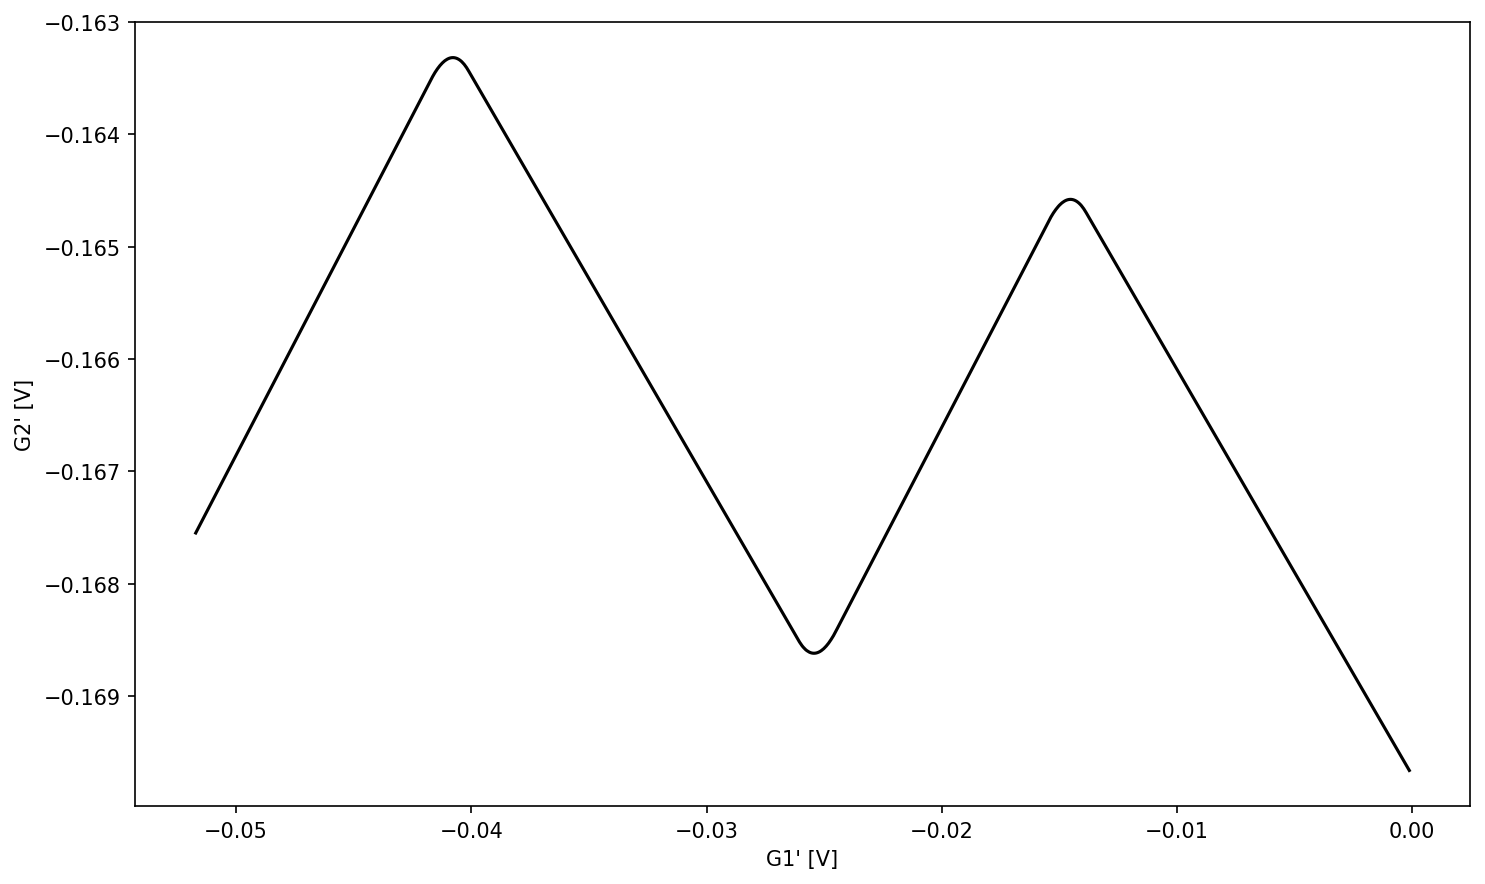

In [6]:
# plot the wavefront
plt.plot(x_eval, y_values, "k")
plt.xlabel("G1' [V]")
plt.ylabel("G2' [V]")
plt.tight_layout()

### Representation with and without tunnel coupling / rounding of interdot transitions

#### Retrieve all bezier anchors of the TCT & set up representation with no tunnel coupling / rounding of interdot transitions

After evaluating & plotting our TCT, we will now retrieve all bezier anchors (which define the rounded part). Instead of calculating the anchors ourself we can use a function provided by SimCATS (`calculate_all_bezier_anchors`). The center anchor for every bezier curve is calculated as the intersection of the two linear parts localized at the two outer anchors (left/right). This intersection point can be used to represent the TCT without rounding of the parts affected by interdot transitions (An interdot transition describes the tunneling of an electron from one dot to another). That is done by setting the left and right anchor (of the TCT params) to the position of the center anchor (and basically deactivating the bezier curve as it has a width of zero).

In [7]:
# get all the bezier anchors, including the middle ones, that are not defined directly
bezier_coords = calculate_all_bezier_anchors(tct_params=specific_tct_params_single, max_peaks=max_peaks, rotation=rotation)

The bezier_coords dictionary contains 3d numpy arrays. The **keys of the dictionary** stand for the max_peaks number (also refered to as TCT ID and further described in section [Controlling the number of interdot transitions using the parameter max_peaks](#max_peaks)). The lowest/first TCT has a max_peaks/ID number of 1. In our case we set the max_peaks/ID number to 2. Therefore, we are interested in the bezier coordinates of the corresponding numpy array.  
The **dimensions of the bezier coordinate array** map to:
1. dim := peak/valley identifier  
2. dim := anchor position (0 = left, 1 = center, 2 = right)  
3. dim := coordinate axis identifier (0 = x-value, 1 = y-value)

We only have one TCT line therefore our dictionary only contains the anchors for that one line. For convenience we save the array containing these to a new variable.

In [8]:
bezier_coords_1D = bezier_coords[2]

To calculate the theoretical wavefront without tunnel coupling, set left and right bezier anchor to an identical point, in this case the center anchor of the first peak.

In [9]:
specific_tct_params_no_tunnel_coupling = specific_tct_params_single.copy()
specific_tct_params_no_tunnel_coupling[4] = bezier_coords_1D[0][1][0]  # x coordinate of center anchor of first peak
specific_tct_params_no_tunnel_coupling[5] = bezier_coords_1D[0][1][1]  # y coordinate of center anchor of first peak
specific_tct_params_no_tunnel_coupling[6] = bezier_coords_1D[0][1][0]  # x coordinate of center anchor of first peak
specific_tct_params_no_tunnel_coupling[7] = bezier_coords_1D[0][1][1]  # y coordinate of center anchor of first peak

y_tct_no_tunnel_coupling = tct_bezier(
    tct_params=specific_tct_params_no_tunnel_coupling, x_eval=x_eval, max_peaks=max_peaks, lut_entries=lut_entries
)

Calculate the extent of the two lead-to-dot transitions (LDTs) (A LDT is a transition where an electron tunnels in (or out) of the dot system from (or to) the leads).

In [10]:
# retrieve max and min values
max_val = np.max(y_tct_no_tunnel_coupling)
min_val = np.min(y_tct_no_tunnel_coupling)

In [11]:
# retrieve the x-extent of the two lead to dot transitions (ldts)
ldt_1_x_start = bezier_coords_1D[0][1][0]  # x coordinate of center anchor of first peak
ldt_1_x_stop = bezier_coords_1D[1][1][0]  # x coordinate of center anchor of first valley
ldt_1_y_start = bezier_coords_1D[0][1][1]  # y coordinate of center anchor of first valley
ldt_1_y_stop = bezier_coords_1D[1][1][1]  # y coordinate of center anchor of first valley


ldt_2_x_start = bezier_coords_1D[1][1][0]  # x coordinate of center anchor of first valley
ldt_2_x_stop = bezier_coords_1D[2][1][0]  # x coordinate of center anchor of second peak
ldt_2_y_start = bezier_coords_1D[1][1][1]  # y coordinate of center anchor of first valley
ldt_2_y_stop = bezier_coords_1D[2][1][1]  # y coordinate of center anchor of first valley

#### Plot the TCT curves with and without tunnel coupling and annotate the parameters necessary to generate/define the TCT.

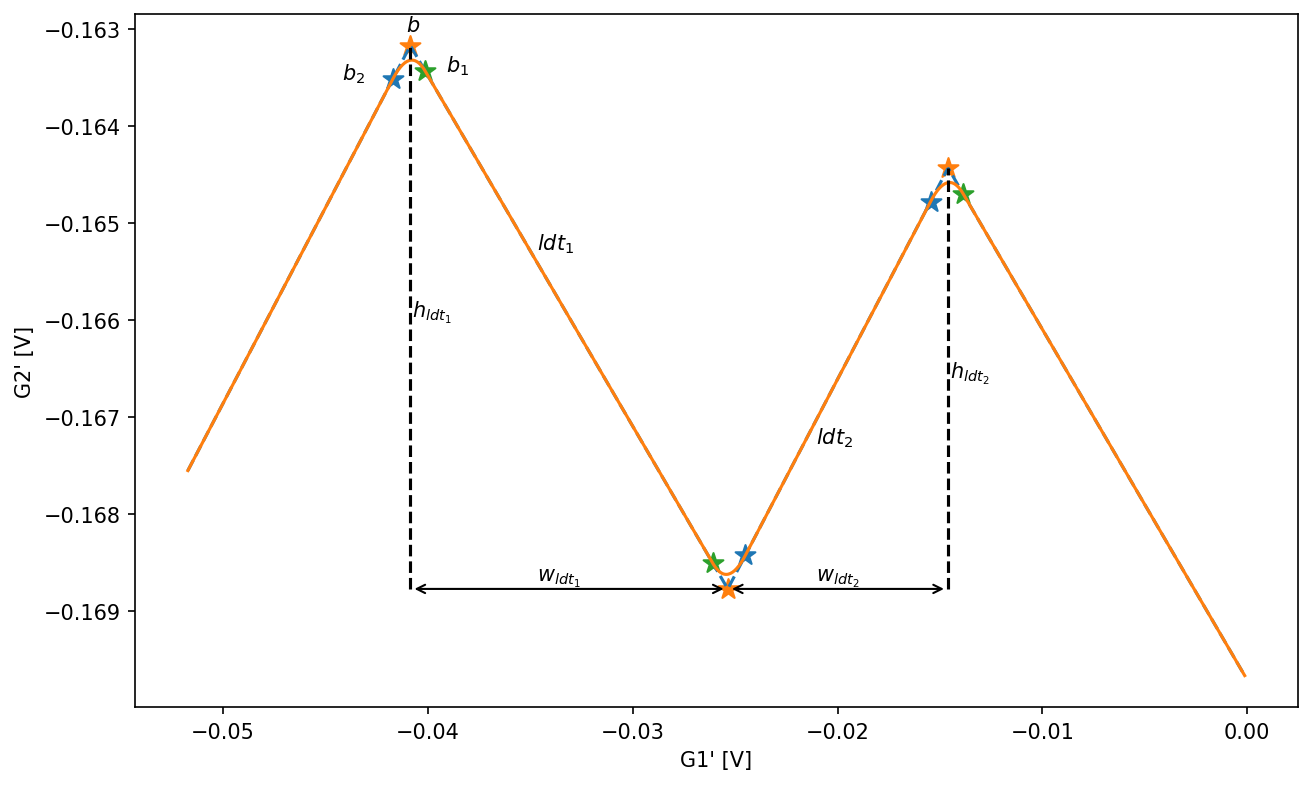

In [12]:
# plot/visualize tct without tunnel coupling
plt.plot(x_eval, y_tct_no_tunnel_coupling, '--')
# plot/visualize tct with tunnel coupling
plt.plot(x_eval, y_values)


# plot/visualize ldt 2
plt.plot([ldt_2_x_stop, ldt_2_x_stop], [ldt_2_y_start, ldt_2_y_stop], "k--")
plt.annotate(text="", xy=(ldt_2_x_stop, ldt_2_y_start), xytext=(ldt_2_x_start, ldt_2_y_start), arrowprops=dict(arrowstyle='<->'))
plt.text(ldt_2_x_start + 0.4*(ldt_2_x_stop - ldt_2_x_start), ldt_2_y_start + 0.00008, "$w_{ldt_{2}}$")
plt.text(ldt_2_x_start + 0.4*(ldt_2_x_stop - ldt_2_x_start), ldt_2_y_start + 0.0015, "$ldt_{2}$")
plt.text(ldt_2_x_stop + 0.0001, ldt_2_y_stop + 0.5*(ldt_2_y_start - ldt_2_y_stop), "$h_{ldt_{2}}$")
# plot/visualize ldt 1
plt.plot([ldt_1_x_start, ldt_1_x_start], [ldt_1_y_stop, ldt_1_y_start], "k--")
plt.annotate(text="", xy=(ldt_1_x_stop, ldt_1_y_stop), xytext=(ldt_1_x_start, ldt_1_y_stop), arrowprops=dict(arrowstyle='<->'))
plt.text(ldt_1_x_start + 0.4*(ldt_1_x_stop - ldt_1_x_start), ldt_1_y_stop + 0.00008, "$w_{ldt_{1}}$")
plt.text(ldt_1_x_start + 0.4*(ldt_1_x_stop - ldt_1_x_start), ldt_1_y_stop + 0.0035, "$ldt_{1}$")
plt.text(ldt_1_x_start + 0.0001, ldt_1_y_stop + 0.5*(ldt_1_y_start - ldt_1_y_stop), "$h_{ldt_{1}}$")
# plot/visualize the bezier anchor coordinates
# first 3 get names
plt.scatter([bezier_coords_1D[0,0,0], bezier_coords_1D[1,2,0], bezier_coords_1D[2,0,0]],
            [bezier_coords_1D[0,0,1], bezier_coords_1D[1,2,1], bezier_coords_1D[2,0,1]],
            marker="*", s=100)
plt.text(bezier_coords_1D[0,0,0]-0.0025, bezier_coords_1D[0,0,1], "$b_{2}$")
plt.scatter([bezier_coords_1D[0,1,0], bezier_coords_1D[1,1,0], bezier_coords_1D[2,1,0]],
            [bezier_coords_1D[0,1,1], bezier_coords_1D[1,1,1], bezier_coords_1D[2,1,1]], 
            marker="*", s=100)
plt.text(bezier_coords_1D[0,1,0]-0.0002, bezier_coords_1D[0,1,1]+0.00015, "$b$")
plt.scatter([bezier_coords_1D[0,2,0], bezier_coords_1D[1,0,0], bezier_coords_1D[2,2,0]],
            [bezier_coords_1D[0,2,1], bezier_coords_1D[1,0,1], bezier_coords_1D[2,2,1]],
            marker="*", s=100)
plt.text(bezier_coords_1D[0,2,0]+0.001, bezier_coords_1D[0,2,1], "$b_{1}$")
plt.xlabel("G1' [V]")
plt.ylabel("G2' [V]")
plt.show()

**lengths of the LDTs**   
len_left $:= w_{ldt_{2}}$   
len_right $:= w_{ldt_{1}}$   

**slopes for $ldt_1$ and $ldt_2$ (linear parts to the left and right of the bezier curve)**   
slope_left $:= \frac{h_{ldt_{2}}}{l_{ldt_{2}}}$   
slope_right $:= \frac{h_{ldt_{1}}}{l_{ldt_{1}}}$   

**coordinates of the bezier anchor sitting on $ldt_{2}$ (left anchor of the first bezier curve)**   
left_anchor_x $:= b_2[0]$   
left_anchor_y $:= b_2[1]$   

**coordinates of the bezier anchor sitting on $ldt_{1}$ (right anchor of the first bezier curve)**   
right_anchor_x $:= b_1[0]$   
right_anchor_y $:= b_1[1]$   

### Rotation of TCTs into the actual voltage space

Rotate the existing points by $ \pi \over 4$ (45°) using a SimCATS helper function and then plot the rotated points. This is the default orientation of the TCTs when simulating.  

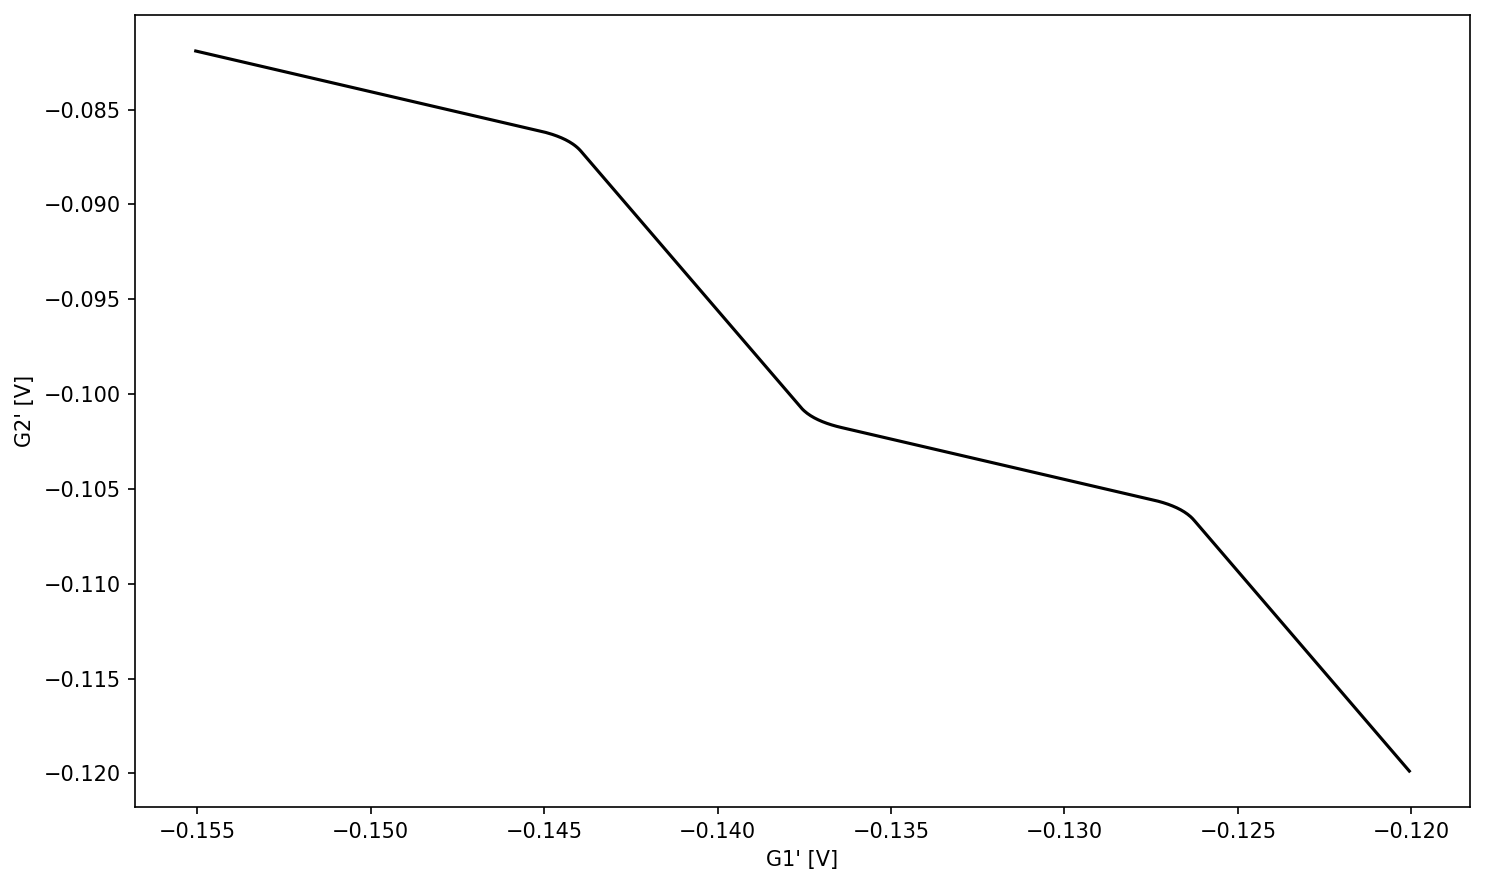

In [13]:
tct_rot = rotate_points(points=np.array([x_eval, y_values]).T, angle=-np.pi / 4)

plt.plot(tct_rot[:, 0], tct_rot[:, 1], "k")
plt.xlabel("G1' [V]")
plt.ylabel("G2' [V]")
plt.tight_layout()

### Controlling the number of interdot transitions using the parameter max_peaks
<a id=max_peaks></a>

We will now change the maximal number of peaks and create and plot the new wavefront. The maximal number of peaks corresponds to the TCT identifier and scales linearly with the number of charges in the system (in the region next to the TCT). A TCT always features as many interdot transitions to the next/higher TCT as defined by max_peaks. The connection to the prior/lower TCT on the other hand consists of max_peaks - 1 interdot transitions.

In [14]:
max_peaks = 6  # change maximal number of peaks
x_right_extended = x_right + 0.1  # move rightmost point further to the right to include all the peaks in the plot
x_eval_max_peaks = np.linspace(x_left, x_right_extended, x_points_num, endpoint=True)

In [15]:
# calculation of the wavefront
y_values_mak_peaks = tct_bezier(tct_params=specific_tct_params_single, x_eval=x_eval_max_peaks, max_peaks=max_peaks, lut_entries=lut_entries)

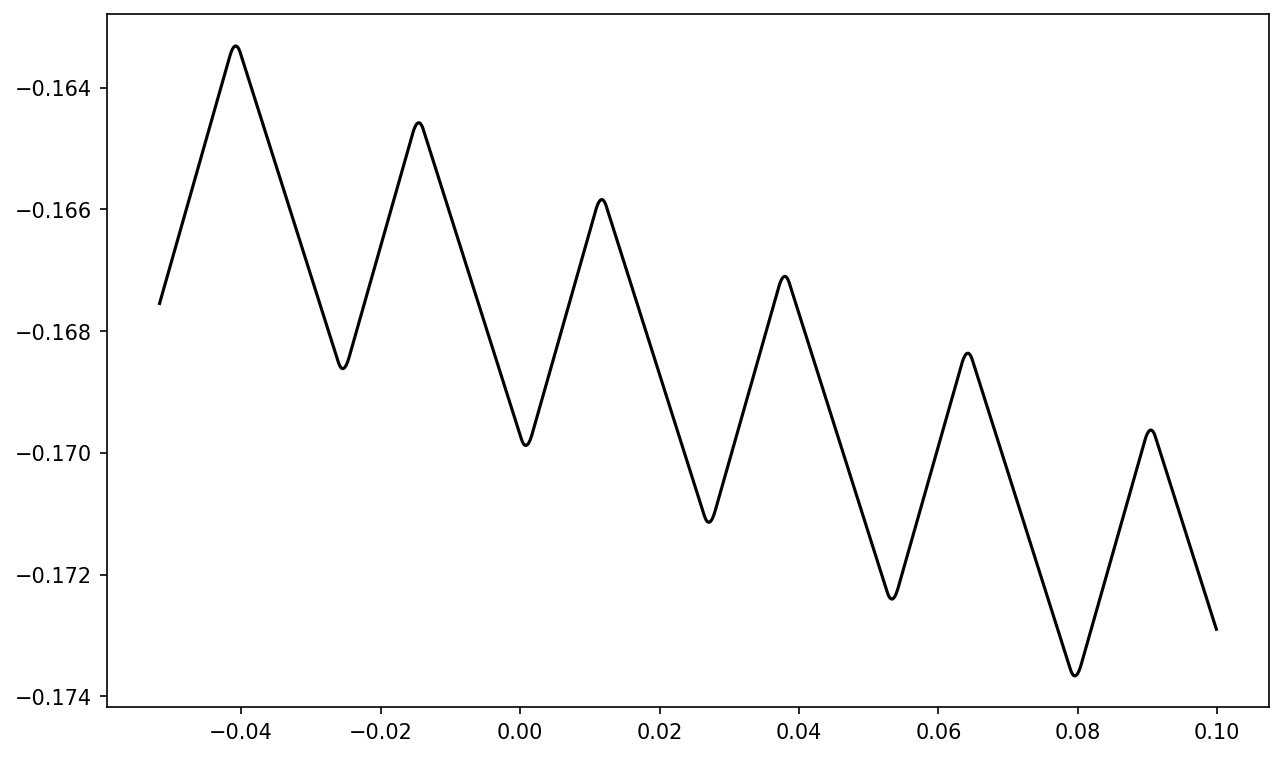

In [16]:
plt.plot(x_eval_max_peaks, y_values_mak_peaks, "k")
plt.show()

### Generating further TCTs by shifting waveforms according to known interdot vector
<a id='sec:shift_vec'></a>

If you can fit one waveform from experimental data and can also get the interdot vector from it you can get the next waveform (assuming its almost the same) by just shifting it. We will now assume, that we extracted the TCT with the ID 2 (separating the regions with a total number of 1 & 2 electrons) and a corresponding interdot vector. Based on this we will calculate the parameters of the TCT with ID 3.

In [17]:
# lengths of the linear parts of the curve
len_left = 0.01075474  # length left
len_right = 0.01549732  # length right

# slopes for left and right parts of the curve
slope_left = 0.40341781  # slope left
slope_right = -0.36136557  # slope right

# coordinates of the left anchor of the first curve
left_anchor_x = -0.04171389  # start position x (bezier curve leftmost point)
left_anchor_y = -0.16351316  # start position y (bezier curve leftmost point)

# coordinates of the right anchor of the first curve
right_anchor_x = -0.04012621  # start position x (bezier curve rightmost point)
right_anchor_y = -0.16343108  # start position y (bezier curve rightmost point)

# tct_params (np.ndarray): Numpy array containing all required parameters to describe the TCT form.
specific_tct_params_w2 = np.array(
    [len_left, len_right, slope_left, slope_right, left_anchor_x, left_anchor_y, right_anchor_x, right_anchor_y]
)

In [18]:
max_peaks = 2  # maximal number of peaks
lut_entries = 1000  # size of lookup table
x_points_num = 10000  # number of x points to evaluate
x_left = left_anchor_x - 0.015  # leftmost x point to evaluate
x_right = right_anchor_x + 0.005 # rightmost x point to evaluate
rotation = 0  # rotation of the transition/bezier line

In [19]:
interdot_vec = np.array([0.0004379547320730603, 0.0036572355686439514]) # get interdot_vec from experimental data

Define x values to evaluate waveforms for.

In [20]:
x_w2 = np.linspace(x_left, x_right, x_points_num, endpoint=True)

Evaluate initial waveform.

In [21]:
y_w2 = tct_bezier(tct_params=specific_tct_params_w2, x_eval=x_w2, max_peaks=max_peaks, lut_entries=lut_entries)

Get coordinates of the bezier anchors.

In [22]:
# get all the bezier anchors, including the middle ones, that are not defined directly
bezier_coords_w2 = calculate_all_bezier_anchors(tct_params=specific_tct_params_w2, max_peaks=max_peaks, rotation=rotation)

Find central bezier anchor of first peak.

In [23]:
center_bezier_anchor = bezier_coords_w2[2][0][1][0], bezier_coords_w2[2][0][1][1] # x coordinate of center anchor of first peak, y coordinate of center anchor of first peak

Find central bezier anchor of first peak, shifted down to the waveform.

In [24]:
center_bezier_anchor_with_tunnel_coupling = center_bezier_anchor[0], tct_bezier(tct_params=specific_tct_params_w2, x_eval=center_bezier_anchor[0], max_peaks=max_peaks, lut_entries=lut_entries)

Calculate the distance between both center anchors.

In [25]:
# calculate the distance from this point to the central bezier anchor
dist_between_center_with_and_without_tunnel = np.linalg.norm([center_bezier_anchor_with_tunnel_coupling[0]-center_bezier_anchor[0], center_bezier_anchor_with_tunnel_coupling[1]-center_bezier_anchor[1]])

Initial interdot vector is between the central anchors with tunnel coupling of both waveforms, but we need the distance between the anchors without tunnel coupling.    
To do this reduce the length of the interdot vector by two times the distance of the central bezier anchor to the curve (`dist_between_center_with_and_without_tunnel`).

In [26]:
interdot_vec_without_tunnel = interdot_vec * (np.linalg.norm(interdot_vec) - 2 * dist_between_center_with_and_without_tunnel) / np.linalg.norm(interdot_vec)

Calculate the corresponding shift vector for the bezier anchors of the shifted waveform.

In [27]:
shift_vec = np.array([- len_right + interdot_vec_without_tunnel[0], - len_right * slope_right + interdot_vec_without_tunnel[1]])

Set up shifted wave form parameters.

In [28]:
specific_tct_params_w3 = specific_tct_params_w2.copy()
specific_tct_params_w3[4] += shift_vec[0]
specific_tct_params_w3[5] += shift_vec[1]
specific_tct_params_w3[6] += shift_vec[0]
specific_tct_params_w3[7] += shift_vec[1]


Calculate shifted waveform.

In [29]:
max_peaks_w3 = max_peaks+1

In [30]:
y_w3 = tct_bezier(tct_params=specific_tct_params_w3, x_eval=x_w2, max_peaks=max_peaks_w3, lut_entries=lut_entries)

Get coordinates of the bezier anchors for the second waveform.

In [31]:
# get all the bezier anchors, including the middle ones, that are not defined directly
bezier_coords_w3 = calculate_all_bezier_anchors(tct_params=specific_tct_params_w3, max_peaks=max_peaks_w3, rotation=rotation)

Define variables to define the first lead to dot transition of the second waveform.

In [32]:
ldt_1_x_start = bezier_coords_w3[3][0][1][0]  # x coordinate of center anchor of first peak
ldt_1_x_stop = bezier_coords_w3[3][1][1][0]  # x coordinate of center anchor of first valley
ldt_1_y_start = bezier_coords_w3[3][0][1][1]  # y coordinate of center anchor of first valley
ldt_1_y_stop = bezier_coords_w3[3][1][1][1]  # y coordinate of center anchor of first valley

Plot and visualize the original and shifted waveform and how the waveform was shifted.

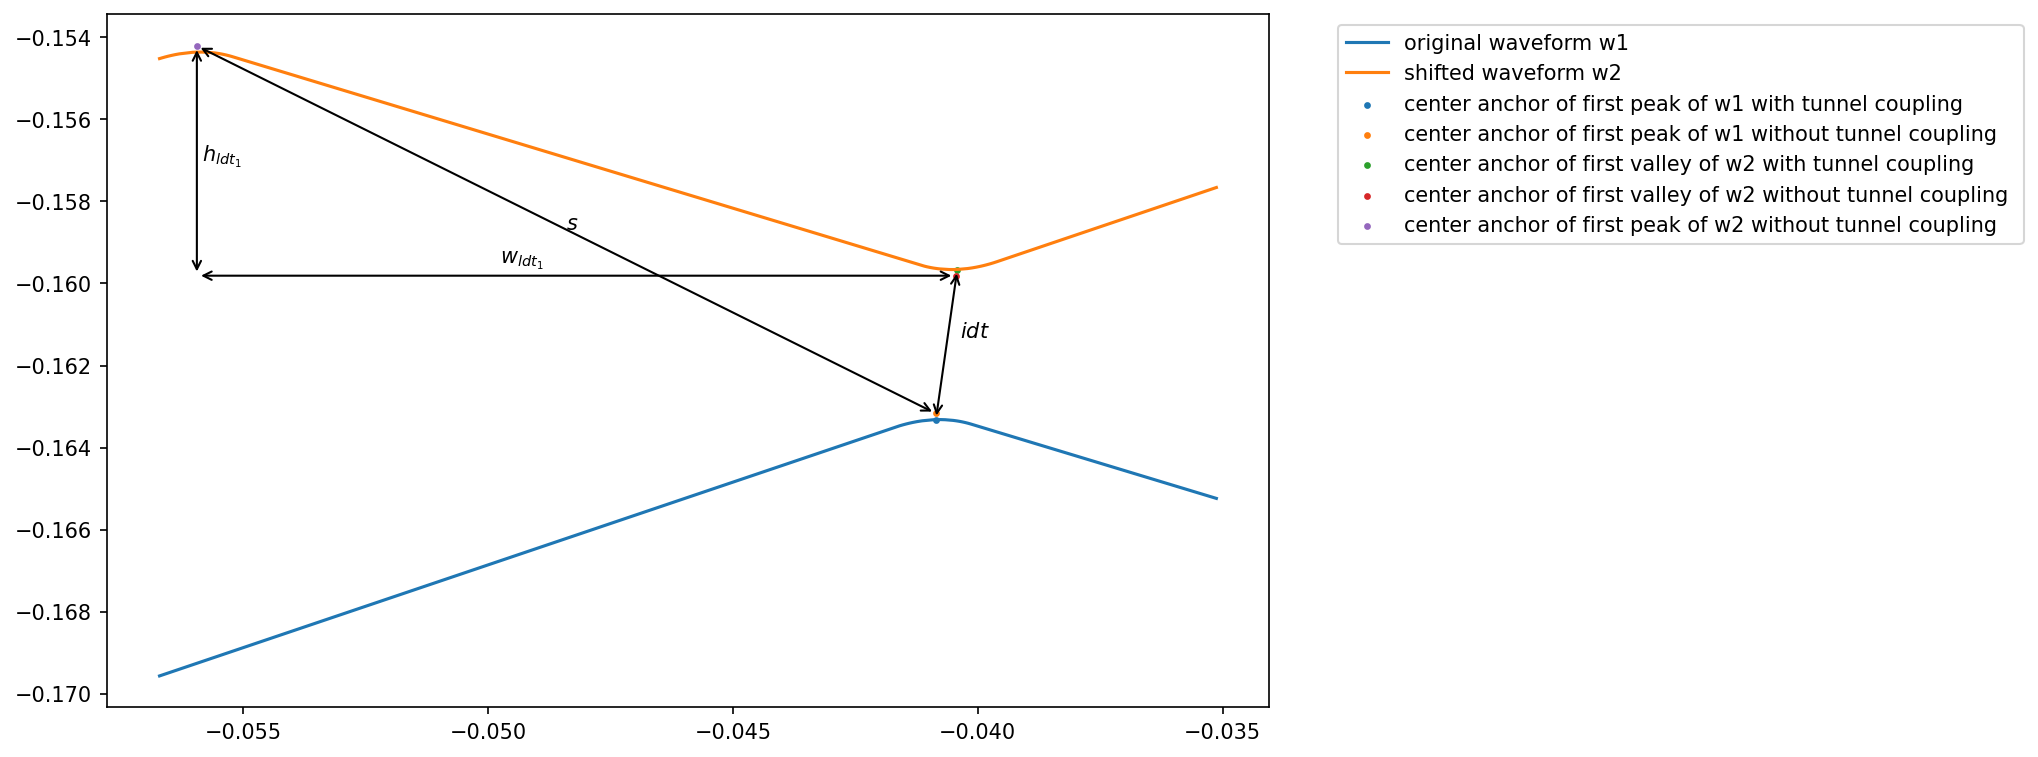

In [33]:
marker_size = 5

# plot both waveforms
plt.plot(x_w2, y_w2, label="original waveform w1")
plt.plot(x_w2, y_w3, label="shifted waveform w2")
# plot center anchor of first peak of w1 with and without tunnel coupling
plt.scatter(center_bezier_anchor_with_tunnel_coupling[0], center_bezier_anchor_with_tunnel_coupling[1], label="center anchor of first peak of w1 with tunnel coupling", s= marker_size)
plt.scatter(center_bezier_anchor[0], center_bezier_anchor[1], label="center anchor of first peak of w1 without tunnel coupling ",s= marker_size)
# plot center anchor of first valley of w2 with and without tunnel coupling
plt.scatter(center_bezier_anchor_with_tunnel_coupling[0]+interdot_vec[0], center_bezier_anchor_with_tunnel_coupling[1]+interdot_vec[1], label="center anchor of first valley of w2 with tunnel coupling ",s= marker_size)
plt.scatter(center_bezier_anchor[0]+interdot_vec_without_tunnel[0], center_bezier_anchor[1]+interdot_vec_without_tunnel[1], label="center anchor of first valley of w2 without tunnel coupling ",s= marker_size)
# plot center anchor of first peak of w2 with and without tunnel coupling
plt.scatter(bezier_coords_w3[3][0][1][0], bezier_coords_w3[3][0][1][1], label="center anchor of first peak of w2 without tunnel coupling ",s= marker_size)
# plot interdot transition vector
plt.annotate(text="", xy=(center_bezier_anchor_with_tunnel_coupling[0], center_bezier_anchor_with_tunnel_coupling[1]), xytext=(center_bezier_anchor_with_tunnel_coupling[0]+interdot_vec[0], center_bezier_anchor_with_tunnel_coupling[1]+interdot_vec[1]), arrowprops=dict(arrowstyle='<->'))
plt.text(center_bezier_anchor_with_tunnel_coupling[0]+ 0.0005, center_bezier_anchor_with_tunnel_coupling[1] + 0.002, "$idt$")
# plot/visualize ldt 1|
plt.annotate(text="", xy=(ldt_1_x_start, ldt_1_y_stop), xytext=(ldt_1_x_start, ldt_1_y_start), arrowprops=dict(arrowstyle='<->'))
plt.annotate(text="", xy=(ldt_1_x_stop, ldt_1_y_stop), xytext=(ldt_1_x_start, ldt_1_y_stop), arrowprops=dict(arrowstyle='<->'))
plt.text(ldt_1_x_start + 0.4*(ldt_1_x_stop - ldt_1_x_start), ldt_1_y_stop + 0.0003, "$w_{ldt_{1}}$")
plt.text(ldt_1_x_start + 0.0001, ldt_1_y_stop + 0.5*(ldt_1_y_start - ldt_1_y_stop), "$h_{ldt_{1}}$")
# plot shift vector
plt.annotate(text="", xy=(center_bezier_anchor[0], center_bezier_anchor[1]), xytext=(bezier_coords_w3[3][0][1][0], bezier_coords_w3[3][0][1][1]), arrowprops=dict(arrowstyle='<->'))
plt.text(center_bezier_anchor[0] + 0.5*(bezier_coords_w3[3][0][1][0]-center_bezier_anchor[0]), center_bezier_anchor[1] + 0.5*(bezier_coords_w3[3][0][1][1]-center_bezier_anchor[1]), "$s$")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

**interdot transition**   
$\vec{idt} := $  interdot_vec_without_tunnel

**lengths of LDT 1**   
$\vec{w_{ldt_{1}}} := \begin{pmatrix}len\_right \\ 0\end{pmatrix}$


**height of LDT1**   
$\vec{h_{ldt_{1}}} := \begin{pmatrix}0 \\ |len\_right \cdot slope\_right|\end{pmatrix} $

**shift vector between the center anchors (of the first peak) of w1 and w2**   
$\vec{s} := \vec{idt} + \vec{w_{ldt_{1}}} + \vec{h_{ldt_{1}}}$

## 2D simulation

We will now have a look at the 2D simulation using TCTs. First, we will go through the algorithm step by step. Then, we will have a look at the function that allows us to carry out a simulation with a single function call.

#### Step by step

Run a two dimensional simulation without the simulation class to show what the class does internally.

##### Set up lead transitions

Get all the wavefronts instead of just a specific one. Before we accessed only one specific TCT of the default config. This time we use the whole list.

In [34]:
specific_tct_params = default_configs["GaAs_v1"]["ideal_csd_config"].tct_params

Define our maximum number of peaks, rotation and cdf type. The wavefronts are usually defined in a voltage space that is rotated by 45 degrees.

In [35]:
max_peaks = 1
rotation = -np.pi / 4
cdf_type = "sigmoid"

Define our sweep ranges and resolution and initialize the lead transition array.

In [36]:
sweep_range_g1 = np.array([-0.175, -0.1])
sweep_range_g2 = np.array([-0.15, -0.075])
resolution = np.array([100, 100])

# Initialize an empty numpy array which will be used to store the lead-dot transition line mask
csd_transitions_2d = np.zeros(resolution[::-1])

In [37]:
# retrieve partially initialized wavefront functions
wf_functions = initialize_tct_functions(tct_params=specific_tct_params, max_peaks=max_peaks)

Retrieve all bezier anchors of the wavefronts (required for the occupation calculation).  This time the dictionary will contain more than one key and value.

In [38]:
# retrieve all bezier anchors of the wavefronts (required for the occupation calculation) and
# usually defined in a voltage space that is rotated by 45 degrees
bezier_coords = calculate_all_bezier_anchors(tct_params=specific_tct_params, max_peaks=max_peaks, rotation=rotation)

The 2D simulation expects the voltages to be sorted from min to max. If this is not the case, the voltages are sorted here and afterward the image is rearranged.   
In the 2D case the transition line mask is used to calculate the occupations in a more efficient way.

In [39]:
csd_transitions_2d = generate_lead_transition_mask_2d(
    csd=csd_transitions_2d,
    volt_limits_g1=np.sort(sweep_range_g1),
    volt_limits_g2=np.sort(sweep_range_g2),
    tct_functions=wf_functions,
    rotation=rotation,
    lut_entries=lut_entries,
)

Plot the lead transitions.

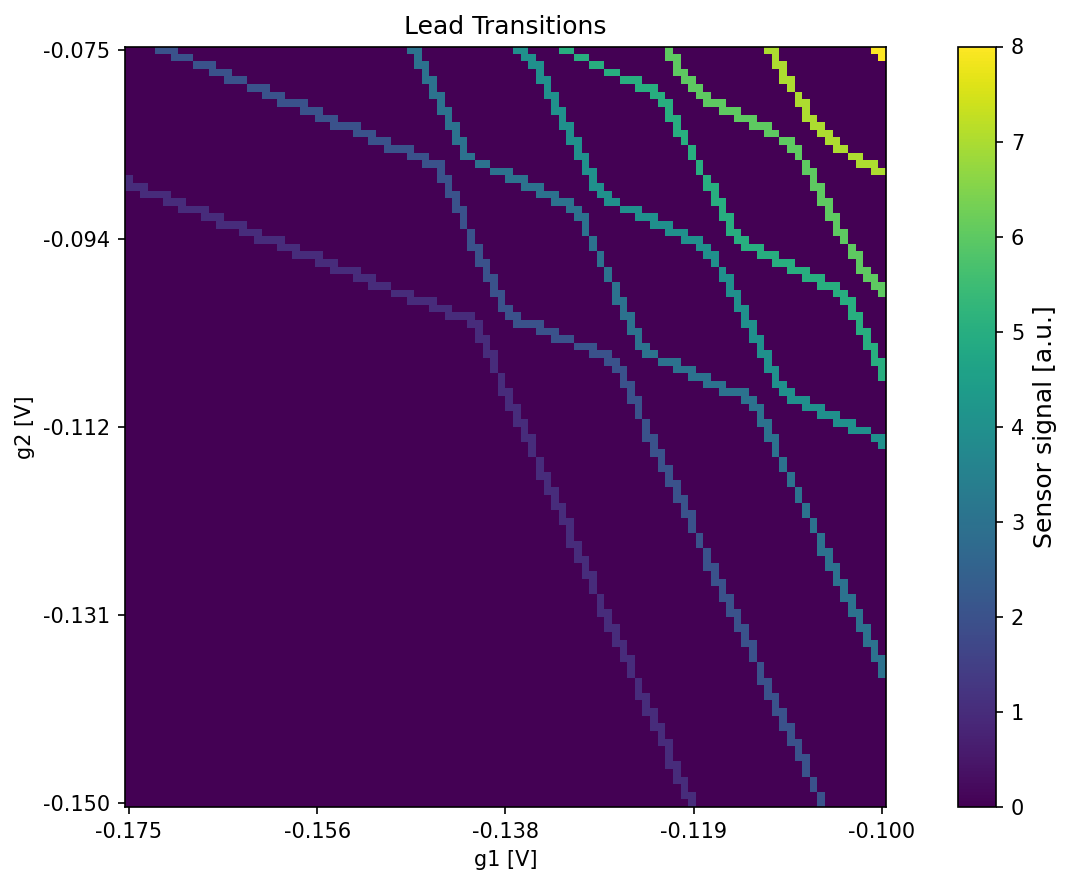

In [40]:
plt.figure()
plot_csd(csd=csd_transitions_2d, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions")

##### Calculate occupations using the lead transition mask


In [41]:
# calculate the occupations
csd_occupations = get_electron_occupation(
    csd=csd_transitions_2d,
    volt_limits_g1=np.sort(sweep_range_g1),
    volt_limits_g2=np.sort(sweep_range_g2),
    bezier_coords=bezier_coords,
    tct_functions=wf_functions,
    rotation=rotation,
    lut_entries=lut_entries,
    cdf_type=cdf_type,
)

Plot the occupation of the two dots.

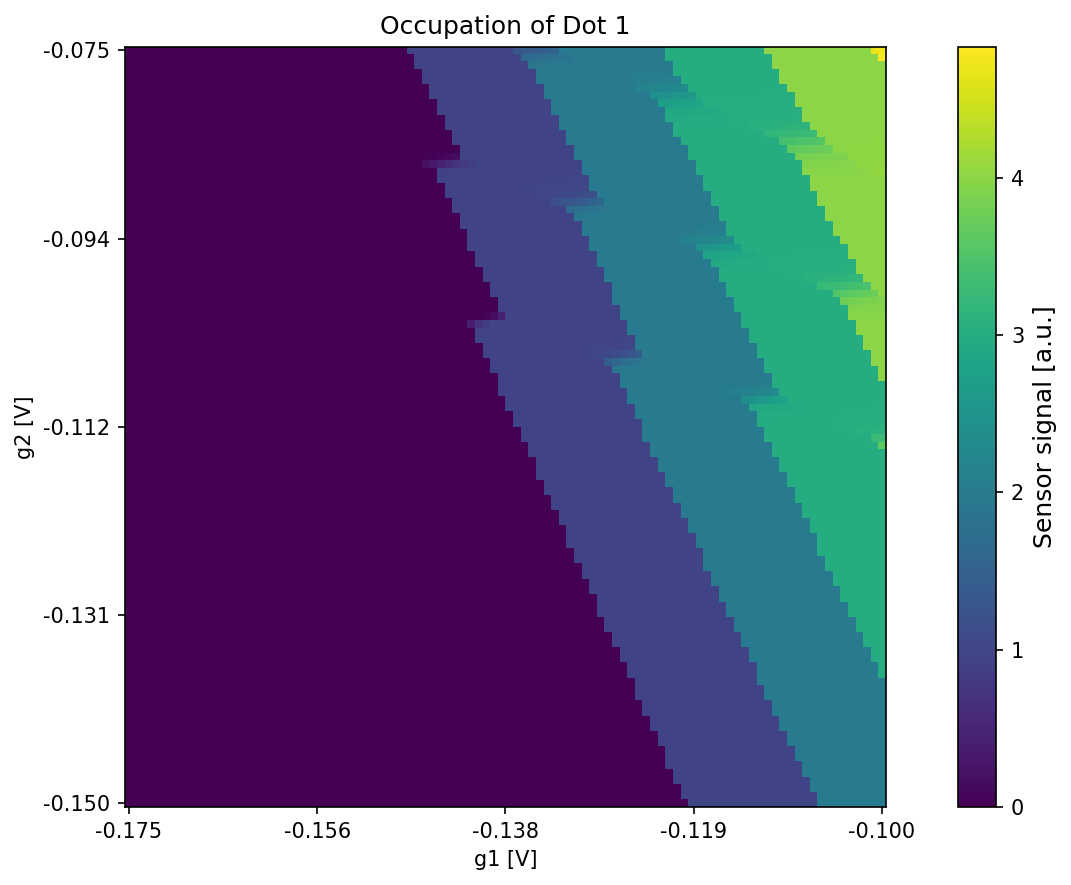

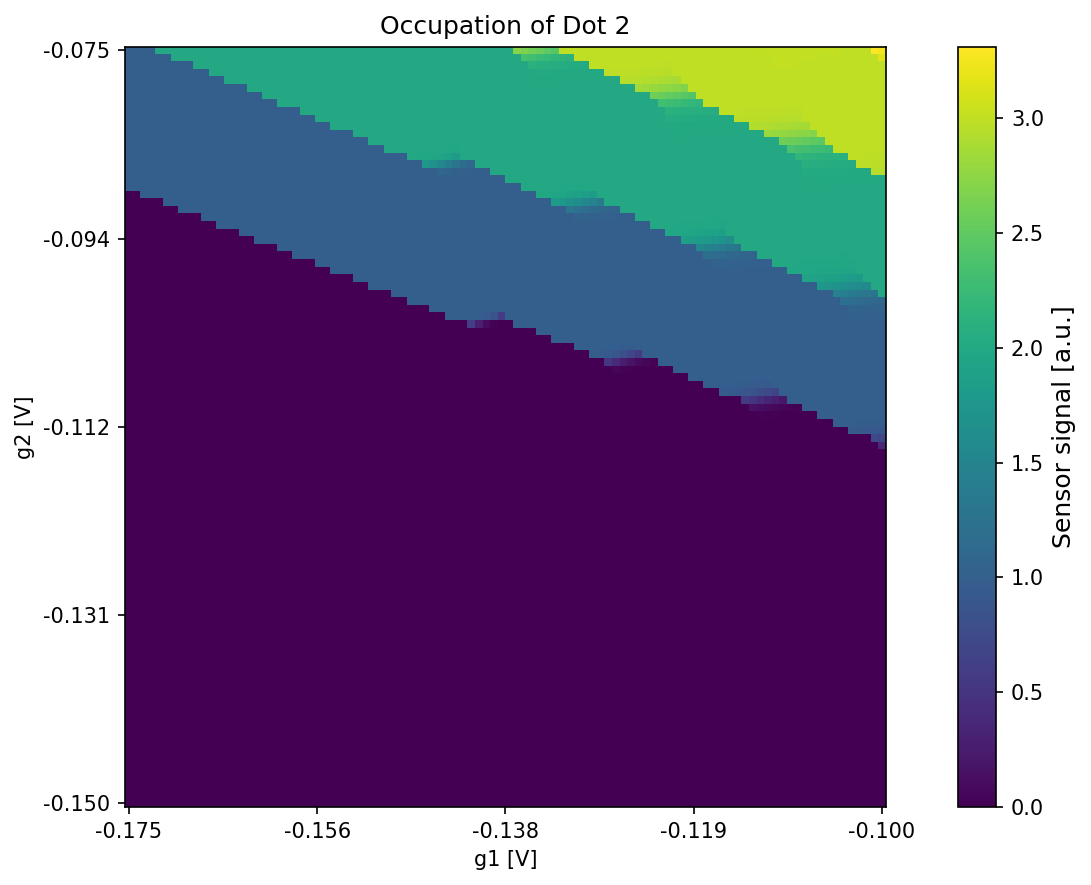

In [42]:
plt.figure()
plot_csd(
    csd=csd_occupations[:, :, 0],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 1",
)
plot_csd(
    csd=csd_occupations[:, :, 1],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 2",
)

#### All-in-one method

Instead of doing these steps by hand you can use `ideal_csd_geometric` instead.

In [43]:
# directly get occupation and transitions
csd_occupations_2d_new, csd_transitions_2d_new = ideal_csd_geometric(
    tct_params=specific_tct_params,
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    resolution=resolution,
    rotation=rotation,
    lut_entries=lut_entries,
    cdf_type=cdf_type,
)

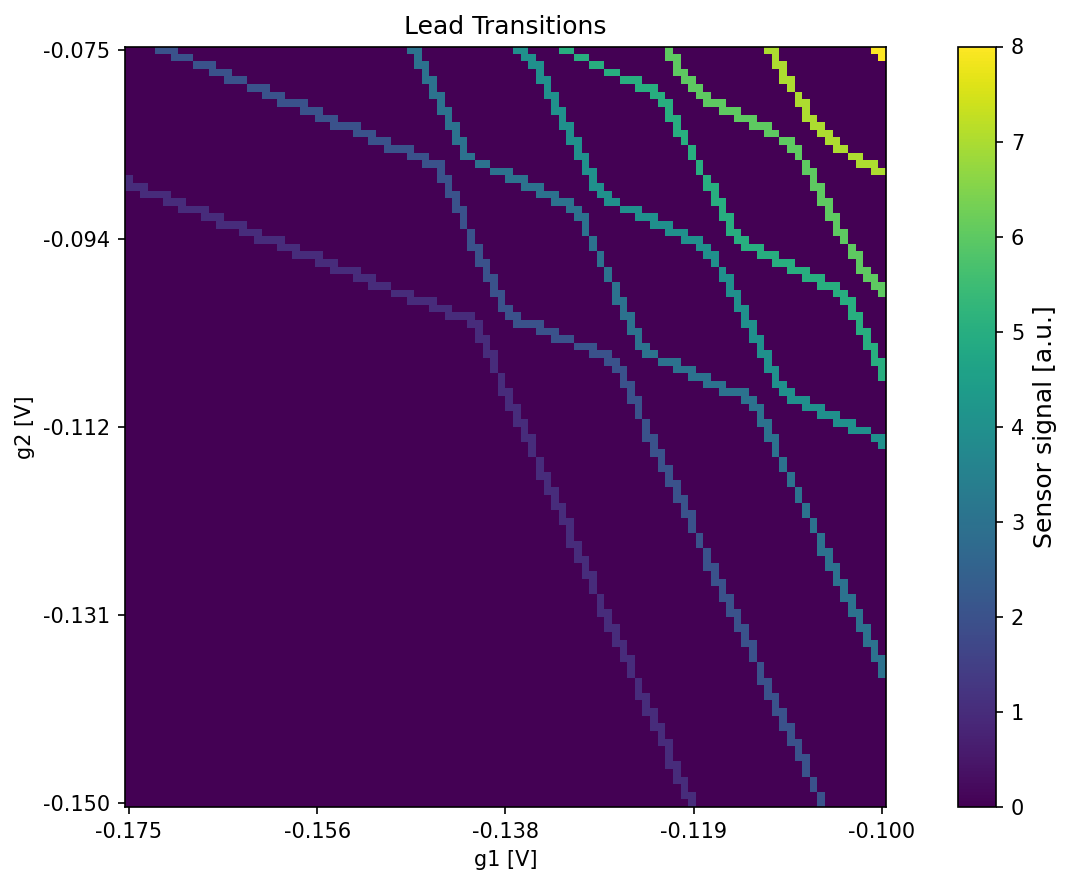

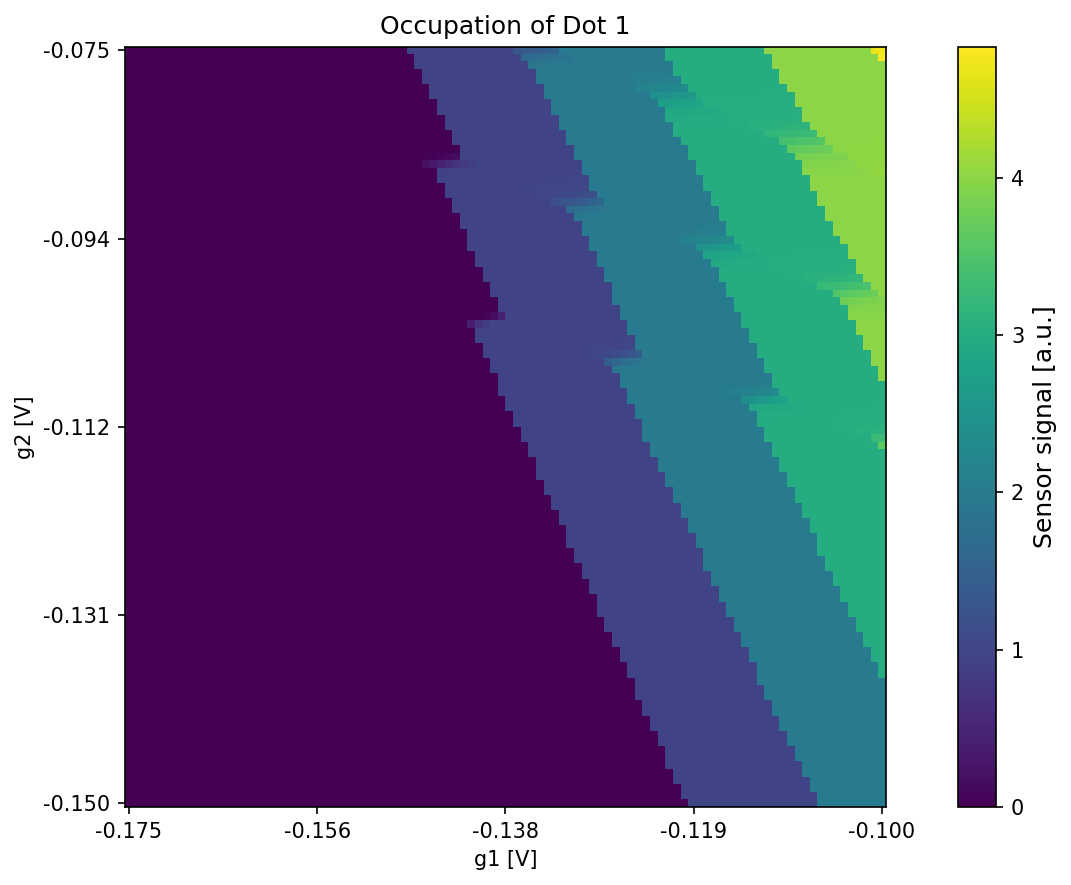

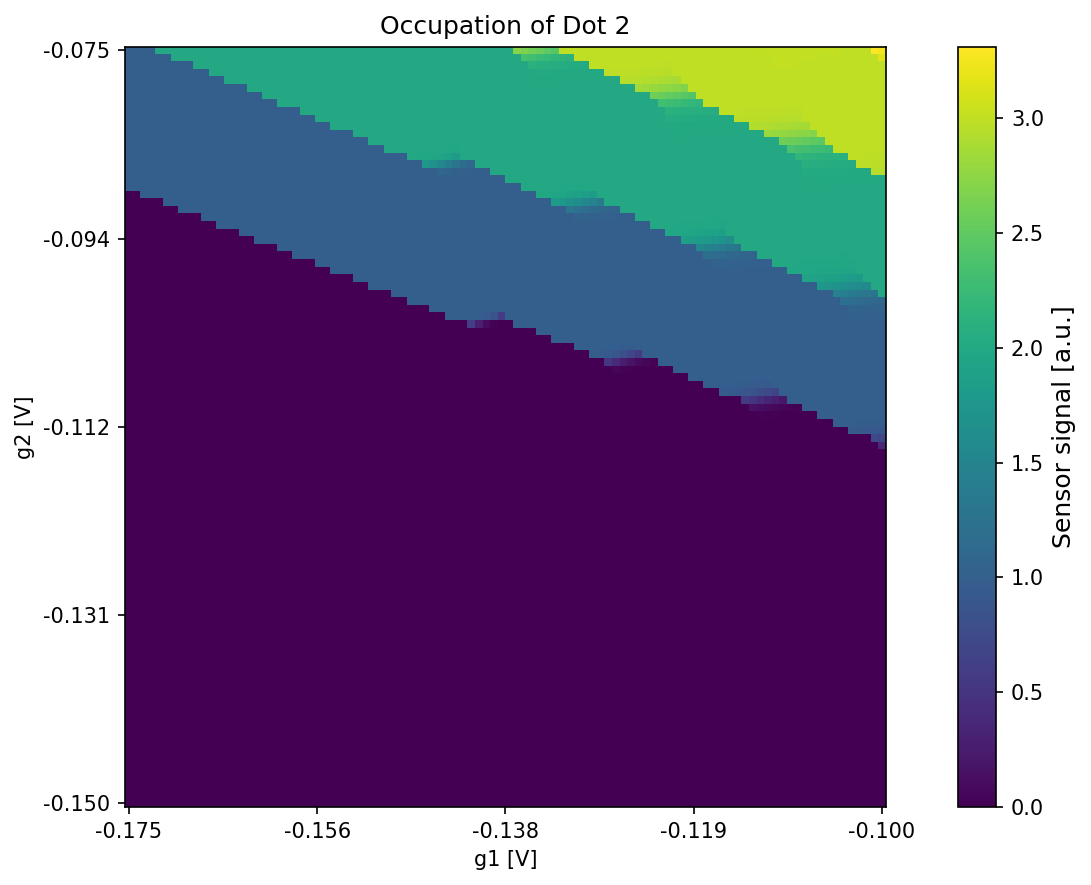

In [44]:
# plot the new occupations and transitions
plot_csd(
    csd=csd_transitions_2d_new, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions"
)
plot_csd(
    csd=csd_occupations_2d_new[:, :, 0],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 1",
)
plot_csd(
    csd=csd_occupations_2d_new[:, :, 1],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 2",
)

## 1D simulation

We will now have a look at the 1D simulation using TCTs. First, we will go through the algorithm step by step. Then, we will have a look at the function that allows us to carry out a simulation with a single function call.

### Step by step

Run a one dimensional simulation without the simulation class to show what the class does internally.

#### Calculate occupation using the TCTs

Define the resolution and initialize the transition array.

In [45]:
resolution_1d = np.array([100])

# Initialize an empty numpy array which will be used to store the lead-dot transition line mask
csd_transitions_1d = np.zeros(resolution_1d[::-1])

Calculate the electron occupation. For 1D, the occupations are calculated first and don't require the lead transition mask.

In [46]:
# calculate the occupations
csd_occupations_1d = get_electron_occupation(
    csd=csd_transitions_1d,
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    bezier_coords=bezier_coords,
    tct_functions=wf_functions,
    rotation=rotation,
    lut_entries=lut_entries,
    cdf_type=cdf_type,
)

Plot the occupation of the two dots.

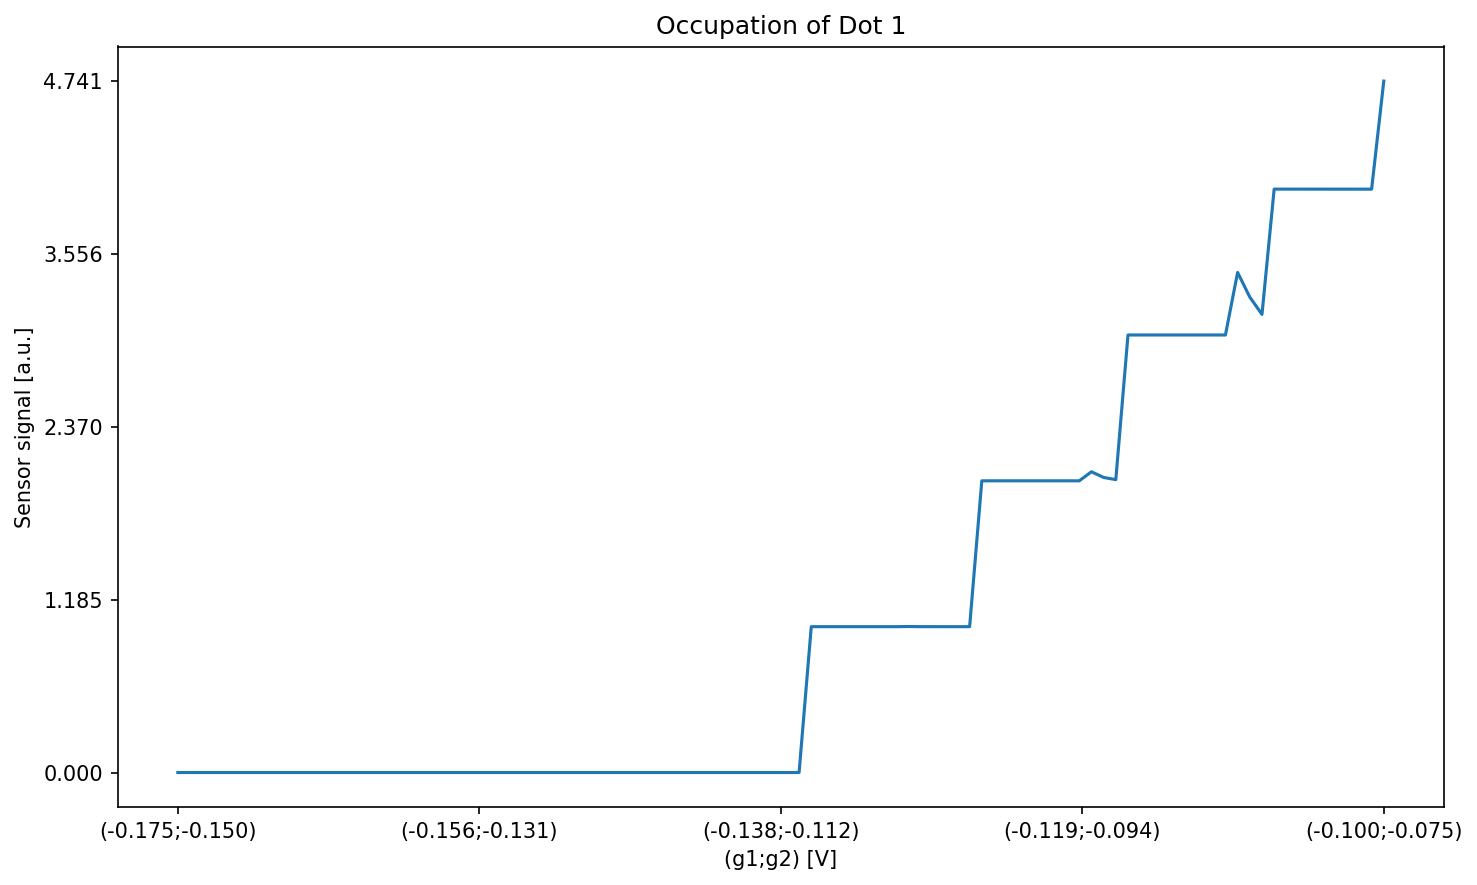

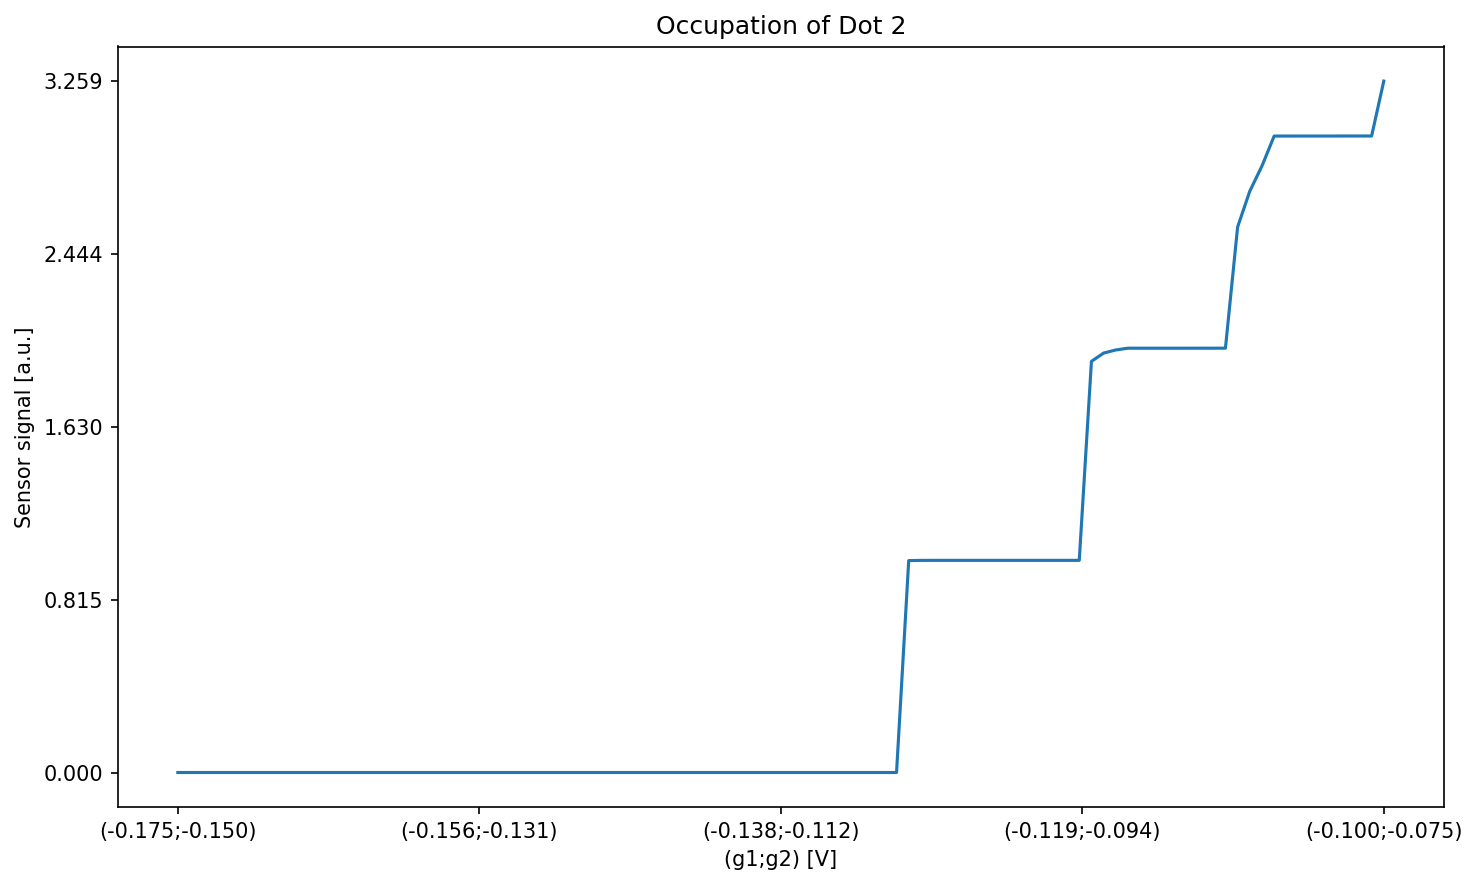

In [47]:
plot_csd(
    csd=csd_occupations_1d[:, 0], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 1"
)
plot_csd(
    csd=csd_occupations_1d[:, 1], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 2"
)

#### Calculate lead transition from occupation

In the 1D case the order of operations is swapped (first occupation then lead transition calculation) contrary to the 2D case where the lead transitions are calculated first to then get the occupations. The reason for this is, that we can't use the lead transition mask to speed up the 1D occupation calculation by finding 2D-regions enclosed by TCTs. But instead we can use the occupations to simplify the calculation of the lead transition mask.

In [48]:
csd_transitions_1d = generate_lead_transition_mask_1d(csd_occ=csd_occupations_1d)

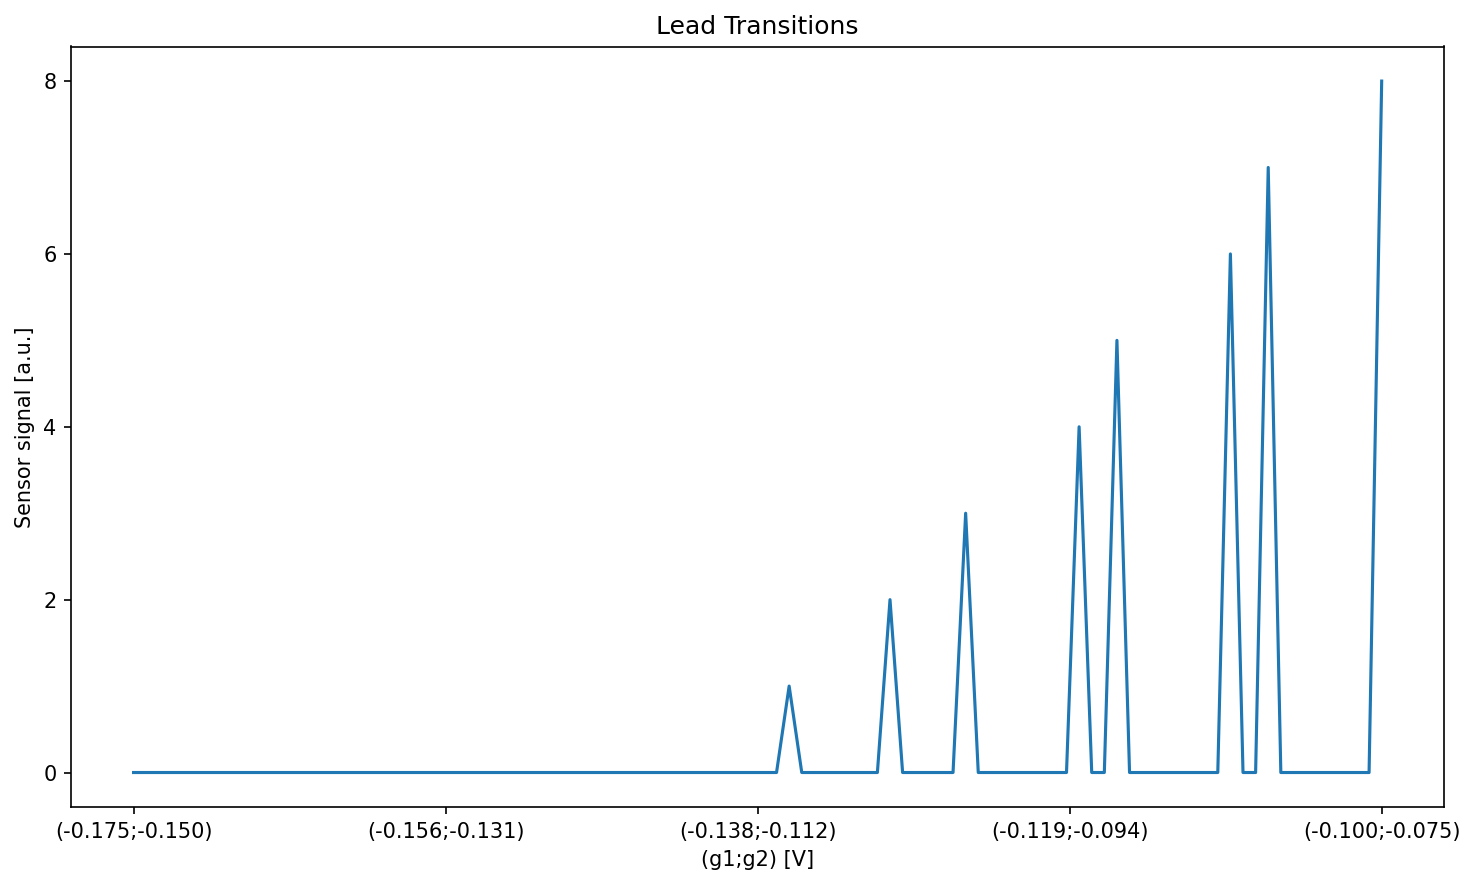

In [49]:
plot_csd(
    csd=csd_transitions_1d, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions"
)

### All-in-one method

Again it is possible to use `ideal_csd_geometric` instead of doing these steps by hand.

In [50]:
# directly get occupation and transitions
csd_occupations_1d_new, csd_transitions_1d_new = ideal_csd_geometric(
    tct_params=specific_tct_params,
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    resolution=resolution_1d,
    rotation=rotation,
    lut_entries=lut_entries,
    cdf_type=cdf_type,
)

Plot the transitions and occupations.

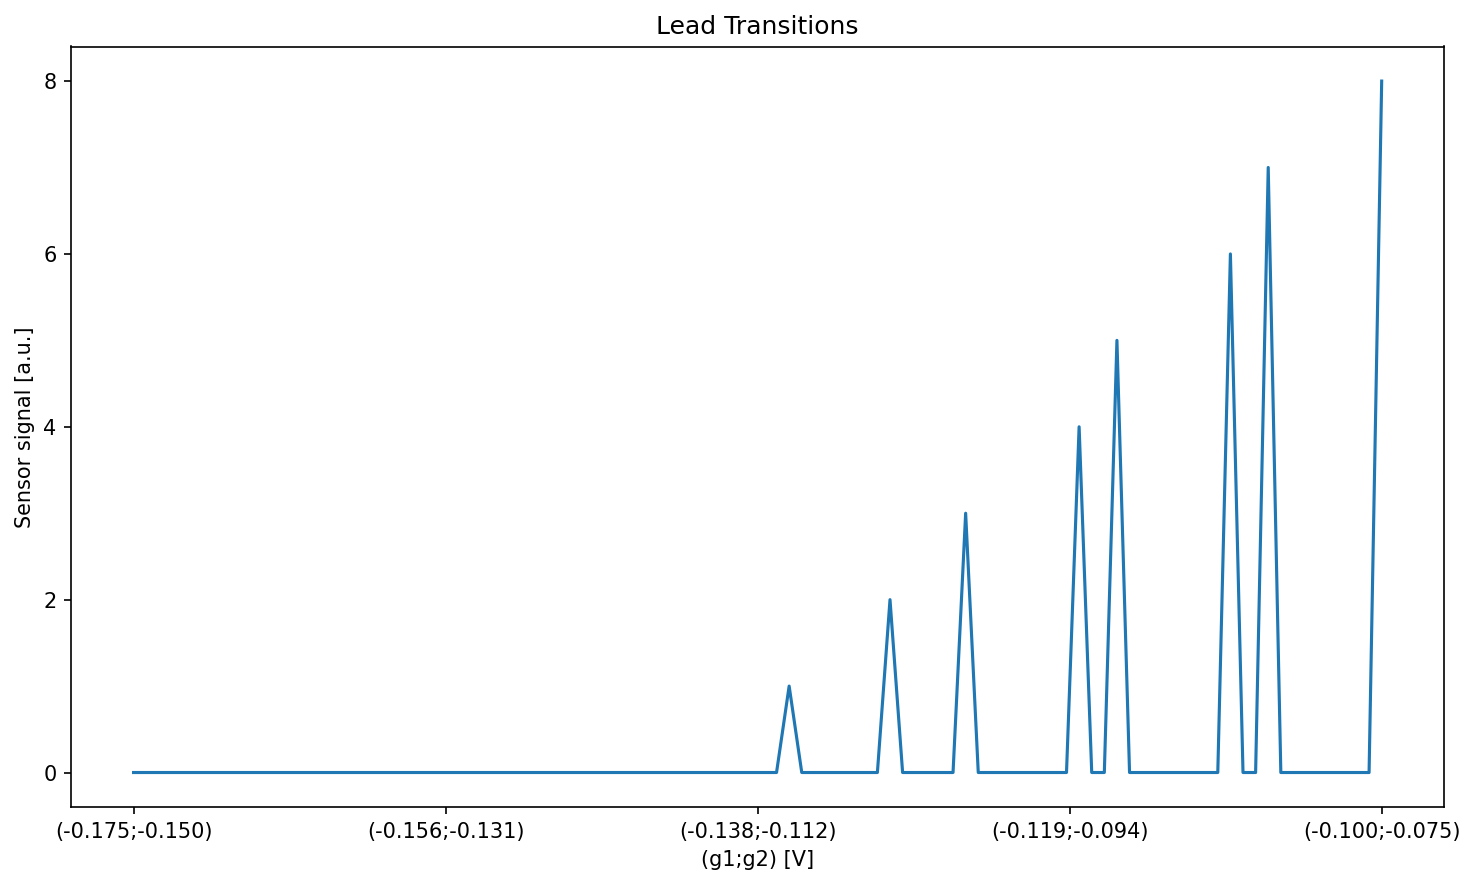

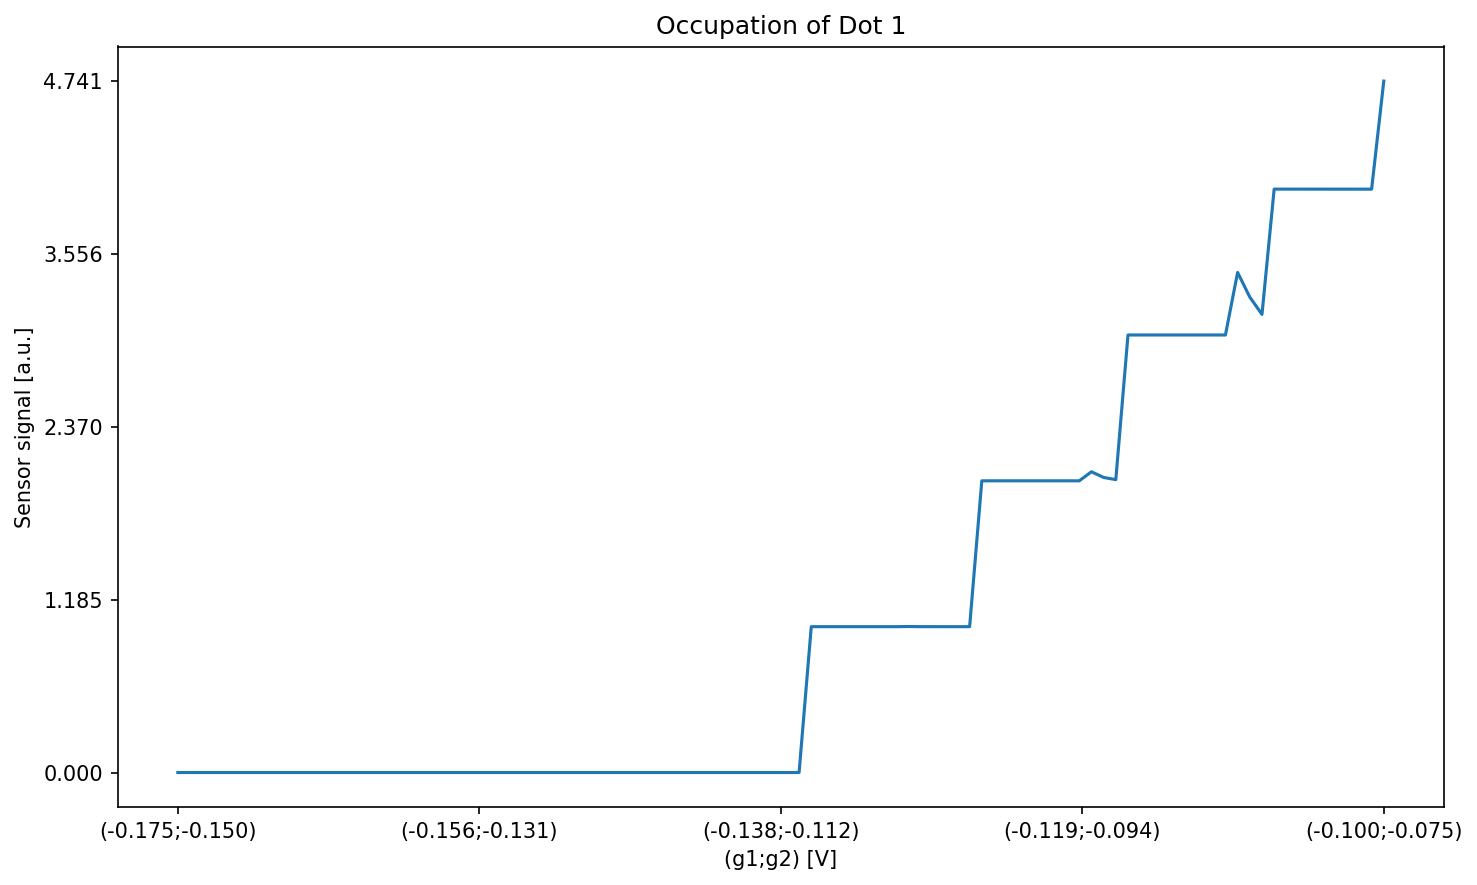

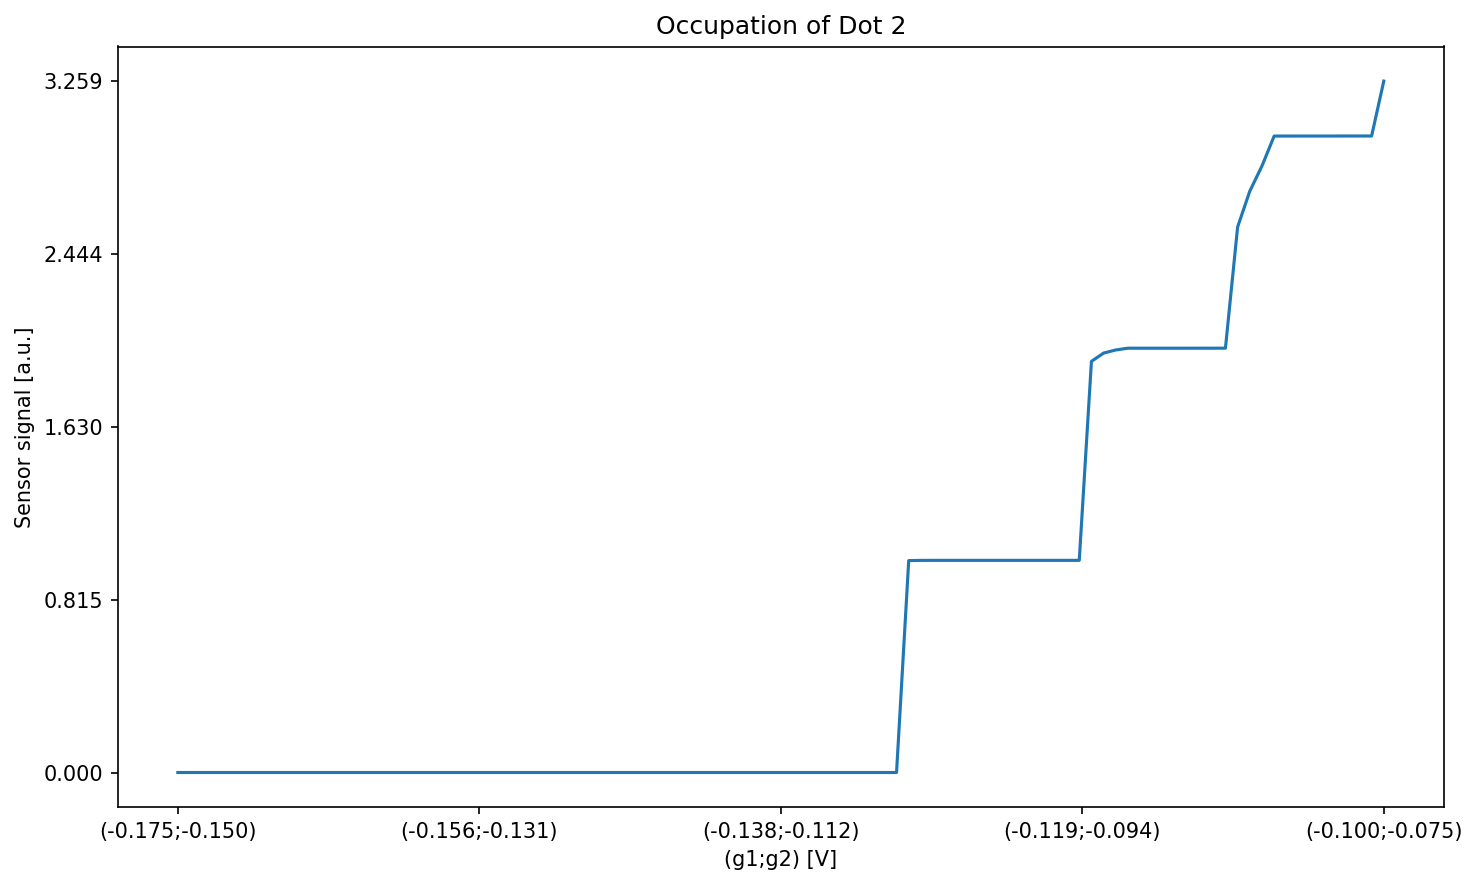

In [51]:
# plot the new occupations and transitions
plot_csd(
    csd=csd_transitions_1d_new, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions"
)
plot_csd(
    csd=csd_occupations_1d_new[:, 0],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 1",
)
plot_csd(
    csd=csd_occupations_1d_new[:, 1],
    volt_limits_g1=sweep_range_g1,
    volt_limits_g2=sweep_range_g2,
    title="Occupation of Dot 2",
)

## Simulation of the interdot transition (using CDFs)
The occupation probability in regions affected by the interdot tunnel coupling is simulated with the help of Cumulative Distribution Functions (CDFs). The CDF is applied perpendicular to the interdot vector (see [Generating further TCTs by shifting waveforms according to known interdot vector](#sec:shift_vec)) to simulate the smooth/blurred transition. SimCATS comes with implementations for Cauchy and Sigmoid/Logistic CDFs.

### Cauchy CDF

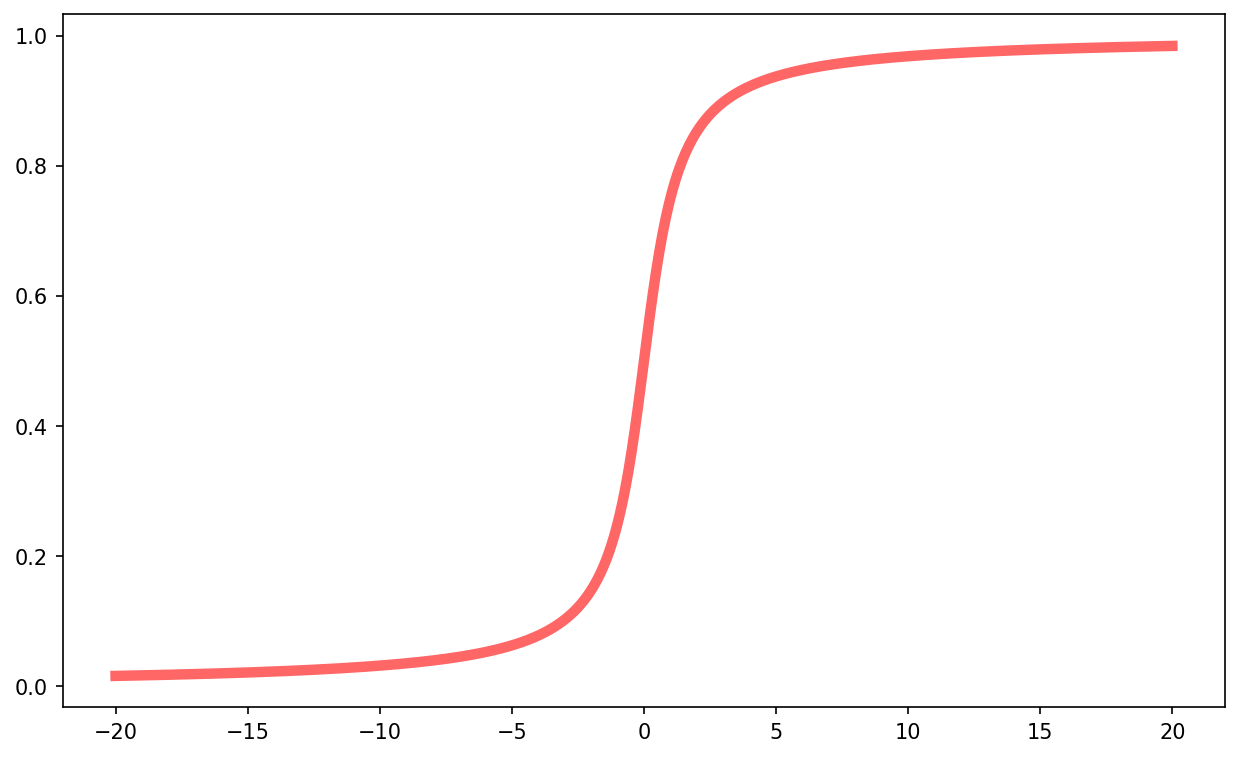

In [52]:
x = np.linspace(-20, 20, 1000)
plt.plot(x, cauchy_cdf(x, x0=0, gam=1), 'r-', lw=5, alpha=0.6)
plt.show()

### Sigmoid/Logistic CDF

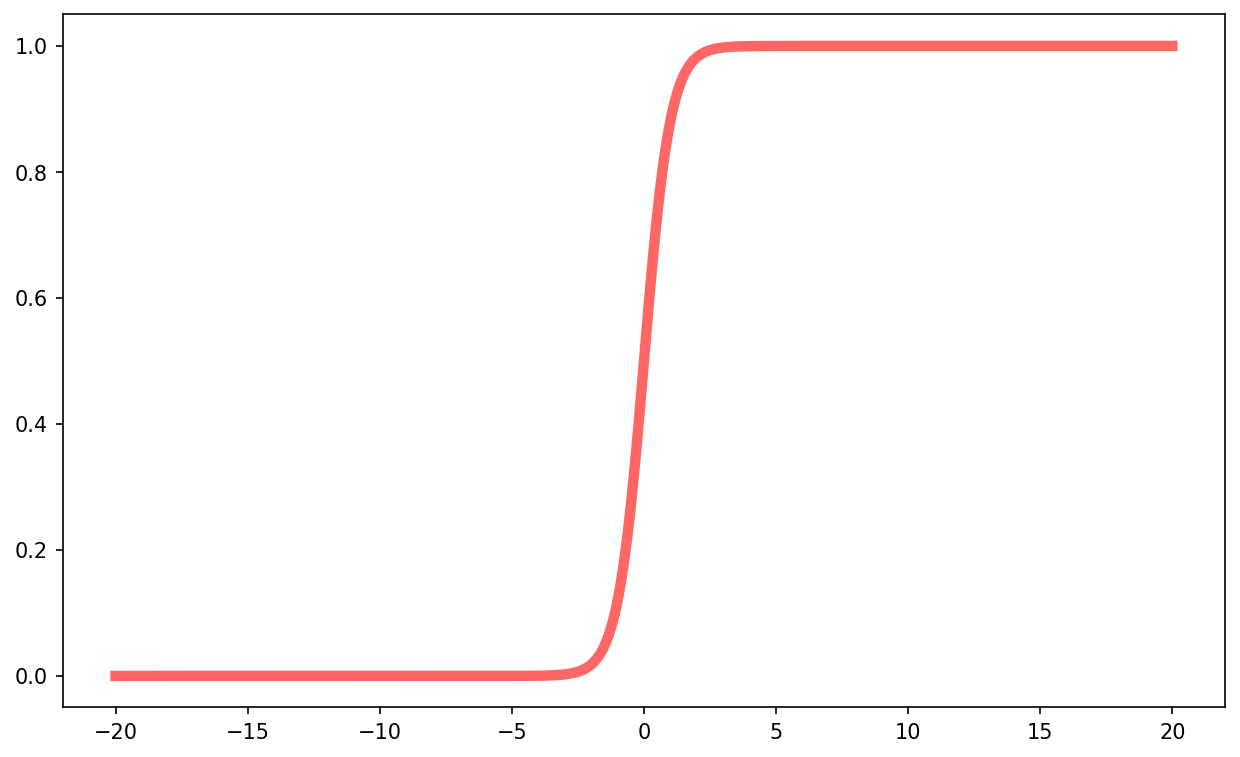

In [53]:
x = np.linspace(-20, 20, 1000)
plt.plot(x, sigmoid_cdf(x, x0=0, gam=1), 'r-', lw=5, alpha=0.6)
plt.show()

## Extraction of labels

Additionally to the returned ground truth occupation of the dots and the TCT mask, it is also possible to create more detailed labels with semantic information about the transitions, if required. This could be for example labels for individual LDTs, which can be created with the help of the function `calculate_all_bezier_anchors` (from `simcats.ideal_csd.geometric`). By passing a TCT config to this function, all bezier anchors, defining the rounded parts affected by interdot tunnel coupling, are retrieved. With these it is then possible to create for example labels for linear parts (required for algorithms that should detect straight lines), which start at the last bezier anchor of a triple point and end at the first bezier anchor of the next triple point. 